# Invasive Ductal Carcinoma Detection using CNNs

## Importing Libraries & Frameworks

In [1]:
# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Directory Control & Image File Handling
import os
import glob
import random
from os import listdir
import zipfile
import cv2

# Machine Learning - Model Building, Training and Validation
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# Model Performance Metrics & Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split

# Dataset Resampling Techniques
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Misc. Utilities
from collections import Counter
from tqdm import tqdm
from IPython.display import Markdown, display

In [2]:
##Unzipping dataset & creating new directory
#zip_file = "breast-histopathology-images.zip"
#output = "tissue-scans-dataset"
#create new local folder in dir
#os.makedirs(output, exist_ok=True)
##extract zipfile
#with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    #zip_ref.extractall(output)
#print("Unzipped successfully!")

## Data Extraction & Organization

In [3]:
dataset_root = r'C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset'

# Creating lists to store paths to image sets
Negative_IDC = []
Positive_IDC = []

for subfolder in os.listdir(dataset_root):
    subfolder_path = os.path.join(dataset_root, subfolder)

    if os.path.isdir(subfolder_path):
        # If Folder is labeled 0
        Negative_IDC += glob.glob(os.path.join(subfolder_path, '0', '*.png'))
        # If folder is labeled 1
        Positive_IDC += glob.glob(os.path.join(subfolder_path, '1', '*.png'))

# Verifying List Contents
# Expected # of Images: 198,738 IDC negative and 78,786 IDC positive
print(f"IDC-Negative Images: {len(Negative_IDC)}")
print(f"IDC-Positive Images: {len(Positive_IDC)}")

IDC-Negative Images: 198738
IDC-Positive Images: 78786


## Data Visualization --> Image Previews

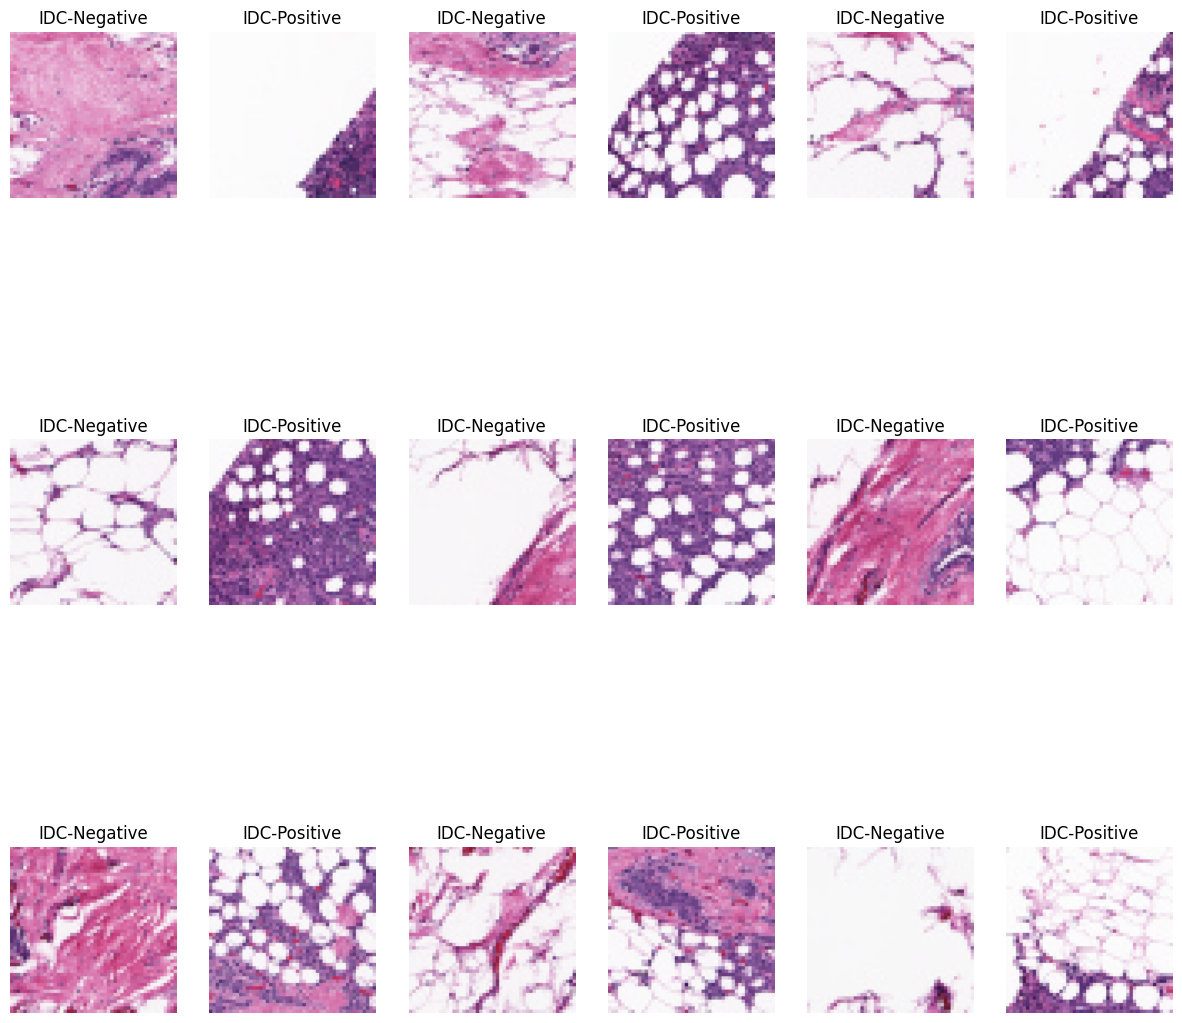

In [4]:
plt.figure(figsize=(15,15))

for i in range(9):
    current_img = image.load_img(Negative_IDC[i], target_size=(100,100))
    current_img = image.img_to_array(current_img)
    plt.subplot(3, 6, 2*i+1)
    plt.axis('off')
    plt.title('IDC-Negative')
    plt.imshow(current_img.astype('uint8'))

for i in range(9):
    current_img = image.load_img(Positive_IDC[i], target_size=(100,100))
    current_img = image.img_to_array(current_img)
    plt.subplot(3, 6, 2*i+2)
    plt.axis('off')
    plt.title('IDC-Positive')
    plt.imshow(current_img.astype('uint8'))

plt.show()

## Data Pre-Processing

In [5]:
# Feature Image List
X = []
# Labels either 0 or 1: 0 --> IDC-Negative, 1 --> IDC-Positive
Y = []


for img_path in tqdm(Negative_IDC):
    current_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if current_img is not None:
        #Resizing every image to be of size 50x50x3
        resized_img = cv2.resize(current_img, (50, 50), interpolation=cv2.INTER_LINEAR)
        X.append(resized_img)
        Y.append(0)
        
# Resize & label cancerous iamges
for img_path in tqdm(Positive_IDC):
    current_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if current_img is not None:
        #Resizing every image to be of size 50x50x3
        resized_img = cv2.resize(current_img, (50, 50), interpolation=cv2.INTER_LINEAR)
        X.append(resized_img)
        Y.append(1) 

# Conversion to NumPy Arrays to Get Dimensions
X = np.array(X)
Y = np.array(Y)
print("Feature array shape: ", X.shape)
print("Label array shape: ", Y.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78786/78786 [00:46<00:00, 1702.09it/s]


Feature array shape:  (277524, 50, 50, 3)
Label array shape:  (277524,)


## Splitting the Dataset

In [6]:
# 80-20: 80% for training, 20% for testing/validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Normalization of feature array, by casting to float32 precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# One-Hot Encoding Labels
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

# Verifying Split of Dataset
print("Training Dataset: ", X_train.shape, Y_train.shape)
print("Testing Dataset: ", X_test.shape, Y_test.shape)

Training Dataset:  (222019, 50, 50, 3) (222019, 2)
Testing Dataset:  (55505, 50, 50, 3) (55505, 2)


## Building CNN Layers

In [7]:
# Marker for loss function: stop trainings if model fails to improve beyond a certain # of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Linear stack of convolutional layers: output of one layer => input to next layer
model = Sequential()

# Convolutional Layers
model.add(Input(shape=(50, 50, 3)))  # Define the input shape here
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Additional Convolutional Layers
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

#print("Training Dataset: ", X_train.shape, Y_train.shape)

In [8]:
# Model Compilation & Summary
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 50, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

## Training, Testing and Validation

### V1: Trained on Unbalanced Dataset

In [9]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 40, batch_size=75)

Epoch 1/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 767s 258ms/step - accuracy: 0.8247 - loss: 0.4160 - val_accuracy: 0.7278 - val_loss: 0.5468
Epoch 2/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 802s 271ms/step - accuracy: 0.8612 - loss: 0.3261 - val_accuracy: 0.7841 - val_loss: 0.4843
Epoch 3/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 810s 273ms/step - accuracy: 0.8694 - loss: 0.3091 - val_accuracy: 0.8159 - val_loss: 0.4255
Epoch 4/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 806s 272ms/step - accuracy: 0.8751 - loss: 0.2967 - val_accuracy: 0.8648 - val_loss: 0.3409
Epoch 5/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 864s 292ms/step - accuracy: 0.8791 - loss: 0.2868 - val_accuracy: 0.8539 - val_loss: 0.3544
Epoch 6/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 859s 290ms/step - accuracy: 0.8809 - loss: 0.2816 - val_accuracy: 0.8545 - val_loss: 0.3613
Epoch 7/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 827s 279ms/step - accuracy: 0.8829 - loss: 0.2748 - val_accuracy: 0.8255 - val_loss: 0.4342
Epoch 8/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 817s 276ms/step - ac

In [10]:
def getClassificationStatistics(model_version_name, model_dir_name):
    #Print Model Version Name
    display(Markdown(f"**{model_version_name}**"))
    
    #Creating new subfolder inside current working directory to organize classification metrics
    original_cwd = os.getcwd()
    
    # Create the subfolder path
    model_metrics_directory = os.path.join(original_cwd, model_dir_name)
    os.makedirs(model_metrics_directory, exist_ok=True)
    
    # Change the working directory to the subfolder
    os.chdir(model_metrics_directory)
    
    #Get Classification Metrics
    Y_pred = model.predict(X_test)
    Y_pred_prob = Y_pred[:, 1]  # Probability for the positive class
    Y_pred_classes = Y_pred.argmax(axis=1)  # Get class with highest probability
    Y_true = Y_test.argmax(axis=1)  # True labels

    #Classification Report
    model_classification_report = classification_report(Y_true, Y_pred_classes, target_names=['IDC(-)', 'IDC(+)'])
    print(model_classification_report)
    
    #Confusion Matrix
    cm = confusion_matrix(Y_true, Y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["IDC-Negative", "IDC-Positive"])
    # Explicitly create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax)  # Use the explicitly created axis
    plt.title("Confusion Matrix")
    # Save the figure
    fig.savefig('ConfusionMatrix.jpg', bbox_inches='tight')  # Save from the figure object
    plt.close(fig)  # Close the figure after saving
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(Y_true, Y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    ax_roc.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color="darkorange", lw=2)
    ax_roc.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver Operating Characteristic")
    ax_roc.legend(loc="lower right")
    fig_roc.savefig('ROC.jpg', bbox_inches='tight')
    plt.close(fig_roc)
    
    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(Y_true, Y_pred_prob)
    fig_pr, ax_pr = plt.subplots(figsize=(8, 6))
    ax_pr.plot(recall, precision, label="Precision-Recall curve", color="blue", lw=2)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision-Recall Curve")
    ax_pr.legend(loc="lower left")
    fig_pr.savefig('PrecisionRecall.jpg', bbox_inches='tight')
    plt.close(fig_pr)
    
    # Training and Validation Loss and Accuracy
    history_dict = history.history
    # Loss Curves
    fig_loss, ax_loss = plt.subplots(figsize=(8, 6))
    ax_loss.plot(history_dict['loss'], label="Training Loss", color="blue")
    ax_loss.plot(history_dict['val_loss'], label="Validation Loss", color="orange")
    ax_loss.set_title("Training and Validation Loss")
    ax_loss.set_xlabel("Epochs")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    fig_loss.savefig('TrainingValidationLoss.jpg', bbox_inches='tight')
    plt.close(fig_loss)
    
    # Accuracy Curves
    fig_acc, ax_acc = plt.subplots(figsize=(8, 6))
    ax_acc.plot(history_dict['accuracy'], label="Training Accuracy", color="blue")
    ax_acc.plot(history_dict['val_accuracy'], label="Validation Accuracy", color="orange")
    ax_acc.set_title("Training and Validation Accuracy")
    ax_acc.set_xlabel("Epochs")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()
    fig_acc.savefig('TrainingValidationAccuracy.jpg', bbox_inches='tight')
    plt.close(fig_acc)

    # Save ALL plots to this subfolder
    print(f"All Plots saved to: {subfolder_path}")
    # Change back to the original working directory
    os.chdir(original_cwd)

# Classification Statistics with Unbalanced Dataset
getClassificationStatistics('Base Model Performance w/ Unbalanced Dataset', 'Base-Model')

**Base Model Performance w/ Unbalanced Dataset**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 71s 41ms/step
              precision    recall  f1-score   support

      IDC(-)       0.93      0.89      0.91     39748
      IDC(+)       0.75      0.82      0.78     15757

    accuracy                           0.87     55505
   macro avg       0.84      0.85      0.84     55505
weighted avg       0.87      0.87      0.87     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5


### V2: Class Weights

In [11]:
neg_samples = np.sum(Y_train[:, 0] == 1)
pos_samples = np.sum(Y_train[:, 1] == 1)

training_data_samples = neg_samples+pos_samples
idc_class_weights = {
    0: training_data_samples/neg_samples, 
    1: training_data_samples/pos_samples,
}

# Training Model w/ Class Weights
model.fit(X_train, Y_train, class_weight=idc_class_weights, validation_data=(X_test, Y_test), epochs = 40, batch_size=75)

Epoch 1/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 872s 294ms/step - accuracy: 0.9641 - loss: 0.1858 - val_accuracy: 0.8573 - val_loss: 0.5154
Epoch 2/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 864s 292ms/step - accuracy: 0.9687 - loss: 0.1608 - val_accuracy: 0.8563 - val_loss: 0.5122
Epoch 3/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 844s 285ms/step - accuracy: 0.9706 - loss: 0.1515 - val_accuracy: 0.8484 - val_loss: 0.5771
Epoch 4/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 909s 307ms/step - accuracy: 0.9719 - loss: 0.1452 - val_accuracy: 0.8612 - val_loss: 0.5294
Epoch 5/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 889s 300ms/step - accuracy: 0.9728 - loss: 0.1436 - val_accuracy: 0.8698 - val_loss: 0.5289
Epoch 6/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 887s 299ms/step - accuracy: 0.9740 - loss: 0.1377 - val_accuracy: 0.8630 - val_loss: 0.5199
Epoch 7/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 889s 300ms/step - accuracy: 0.9736 - loss: 0.1372 - val_accuracy: 0.8637 - val_loss: 0.5789
Epoch 8/40
2961/2961 ━━━━━━━━━━━━━━━━━━━━ 882s 298ms/step - ac

In [12]:
# Classification Statistics after applying Class Weights
getClassificationStatistics('Model Performance w/ Class Weights', 'Class-Weights')

**Model Performance w/ Class Weights**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step
              precision    recall  f1-score   support

      IDC(-)       0.92      0.90      0.91     39748
      IDC(+)       0.76      0.80      0.78     15757

    accuracy                           0.87     55505
   macro avg       0.84      0.85      0.84     55505
weighted avg       0.87      0.87      0.87     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5


### V3: Rebalancing Dataset w/ Undersampling

In [13]:
# Verify current training data shape
print("Current Feature shape:", X_train.shape)
print("Current Label shape:", Y_train.shape)

# Verify Label Breakdown, before resampling
imb_negatives = np.sum(Y_train[:, 0] == 1)
imb_positives = np.sum(Y_train[:, 1] == 1)
print(f"Before resampling, # of negative labels: {imb_negatives}")
print(f"Before resampling, # of positive labels: {imb_positives}")

# Initialize undersampler
undersampler = RandomUnderSampler(random_state = 42)

# Flatten images for undersampling
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_train_us, Y_train_us = undersampler.fit_resample(X_train_flattened, Y_train)

# Restore feature images to normal dimensions
X_train_us = X_train_us.reshape(-1, 50, 50, 3)

# Verify training data shape after resampling
print("Resampled feature shape:", X_train_us.shape)
print("Resampled label shape:", Y_train_us.shape)

# Verify label distribution after resampling (flattened in the process)
reb_us_negatives = np.sum(Y_train_us == 0)
reb_us_positives = np.sum(Y_train_us == 1)
print(f"Before resampling, # of negative labels: {reb_us_negatives}")
print(f"Before resampling, # of positive labels: {reb_us_positives}")

# Restore Label to original shape, by One-Hot Encoding
Y_train_us = to_categorical(Y_train_us, num_classes=2)
print(f"Shape of Y_train_us after one-hot encoding: {Y_train_us.shape}")

Current Feature shape: (222019, 50, 50, 3)
Current Label shape: (222019, 2)
Before resampling, # of negative labels: 158990
Before resampling, # of positive labels: 63029
Resampled feature shape: (126058, 50, 50, 3)
Resampled label shape: (126058, 1)
Before resampling, # of negative labels: 63029
Before resampling, # of positive labels: 63029
Shape of Y_train_us after one-hot encoding: (126058, 2)


In [14]:
history = model.fit(X_train_us, Y_train_us, validation_data=(X_test, Y_test), epochs = 40, batch_size=75)

Epoch 1/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 515s 306ms/step - accuracy: 0.9862 - loss: 0.0432 - val_accuracy: 0.8705 - val_loss: 0.6661
Epoch 2/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 531s 316ms/step - accuracy: 0.9899 - loss: 0.0291 - val_accuracy: 0.8704 - val_loss: 0.6905
Epoch 3/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 518s 308ms/step - accuracy: 0.9907 - loss: 0.0268 - val_accuracy: 0.8724 - val_loss: 0.6553
Epoch 4/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 518s 308ms/step - accuracy: 0.9905 - loss: 0.0279 - val_accuracy: 0.8713 - val_loss: 0.6891
Epoch 5/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 526s 313ms/step - accuracy: 0.9912 - loss: 0.0265 - val_accuracy: 0.8704 - val_loss: 0.6719
Epoch 6/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 514s 306ms/step - accuracy: 0.9915 - loss: 0.0248 - val_accuracy: 0.8761 - val_loss: 0.6662
Epoch 7/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 506s 301ms/step - accuracy: 0.9913 - loss: 0.0254 - val_accuracy: 0.8655 - val_loss: 0.7489
Epoch 8/40
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 513s 305ms/step - ac

In [15]:
# Classification Statistics after Undersampling
getClassificationStatistics('Model Performance w/ Randomly Undersampled Data', 'Undersampling')

**Model Performance w/ Randomly Undersampled Data**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 87s 50ms/step
              precision    recall  f1-score   support

      IDC(-)       0.94      0.85      0.90     39748
      IDC(+)       0.70      0.87      0.78     15757

    accuracy                           0.86     55505
   macro avg       0.82      0.86      0.84     55505
weighted avg       0.87      0.86      0.86     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5


### V4: Rebalancing w/ SMOTE

In [16]:
# Flattening features and label sets
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state = 42)
X_smote, Y_smote = smote.fit_resample(X_train_flattened, Y_train)
X_smote = X_smote.reshape(X_smote.shape[0], 50, 50, 3)

# One-Hot Encoding Flattened Variables & verifying results
print(Y_smote.shape)
Y_smote = to_categorical(Y_smote, num_classes=2)
print(Y_smote.shape)

(317980, 1)
(317980, 2)


In [17]:
history = model.fit(X_smote, Y_smote, validation_data=(X_test, Y_test), epochs = 40, batch_size=75)

Epoch 1/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1373s 324ms/step - accuracy: 0.9789 - loss: 0.0626 - val_accuracy: 0.8726 - val_loss: 0.5128
Epoch 2/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1388s 327ms/step - accuracy: 0.9865 - loss: 0.0379 - val_accuracy: 0.8731 - val_loss: 0.5605
Epoch 3/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1355s 320ms/step - accuracy: 0.9883 - loss: 0.0335 - val_accuracy: 0.8611 - val_loss: 0.6024
Epoch 4/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1375s 324ms/step - accuracy: 0.9889 - loss: 0.0302 - val_accuracy: 0.8722 - val_loss: 0.5859
Epoch 5/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1483s 350ms/step - accuracy: 0.9904 - loss: 0.0267 - val_accuracy: 0.8659 - val_loss: 0.6335
Epoch 6/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1424s 336ms/step - accuracy: 0.9908 - loss: 0.0260 - val_accuracy: 0.8757 - val_loss: 0.6299
Epoch 7/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1271s 300ms/step - accuracy: 0.9917 - loss: 0.0241 - val_accuracy: 0.8668 - val_loss: 0.6582
Epoch 8/40
4240/4240 ━━━━━━━━━━━━━━━━━━━━ 1300s 307ms/s

In [18]:
# Classification Report after SMOTE (oversampling)
getClassificationStatistics('Model Performance w/ Synthetic Minority Oversampling Technique (SMOTE)', 'SMOTE')

**Model Performance w/ Synthetic Minority Oversampling Technique (SMOTE)**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 100s 57ms/step
              precision    recall  f1-score   support

      IDC(-)       0.92      0.89      0.91     39748
      IDC(+)       0.75      0.80      0.78     15757

    accuracy                           0.87     55505
   macro avg       0.84      0.85      0.84     55505
weighted avg       0.87      0.87      0.87     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5


### V5: Augmenting the Dataset

#### V5.1: SMOTE & Data Augmentation

In [19]:
data_generator = ImageDataGenerator(
    # Provide 45 degrees of freedom, to rotate images 
    rotation_range=45,
    
    # Provide upto 10% threshold to shift images vertically or horizontally
    width_shift_range=0.1,
    height_shift_range=0.1,
    
    # Provide upto 25% threshold to zoom into images
    zoom_range=0.25,
    
    # Flip images either horizontally or vertically, at random
    horizontal_flip=True,       
    vertical_flip=False,
    fill_mode='nearest'         
)

# Fetch augmented data from generator
augmented_data = data_generator.flow(X_smote, Y_smote, batch_size=32)

# Train model on augmented data
model.fit(augmented_data, validation_data=(X_test, Y_test), epochs = 40, steps_per_epoch=len(X_smote) // 32)

Epoch 1/40


C:\Users\advay\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9936/9936 ━━━━━━━━━━━━━━━━━━━━ 2311s 232ms/step - accuracy: 0.8811 - loss: 0.3107 - val_accuracy: 0.8654 - val_loss: 0.3125
Epoch 2/40
   1/9936 ━━━━━━━━━━━━━━━━━━━━ 34:04 206ms/step - accuracy: 0.9375 - loss: 0.1476

C:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9936/9936 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.9375 - loss: 0.1476 - val_accuracy: 0.8655 - val_loss: 0.3124
Epoch 3/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 2231s 225ms/step - accuracy: 0.8976 - loss: 0.2482 - val_accuracy: 0.8698 - val_loss: 0.2971
Epoch 4/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step - accuracy: 0.9375 - loss: 0.1951 - val_accuracy: 0.8698 - val_loss: 0.2967
Epoch 5/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 2229s 224ms/step - accuracy: 0.9019 - loss: 0.2399 - val_accuracy: 0.8799 - val_loss: 0.2827
Epoch 6/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - accuracy: 0.8125 - loss: 0.3669 - val_accuracy: 0.8802 - val_loss: 0.2824
Epoch 7/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 2236s 225ms/step - accuracy: 0.9049 - loss: 0.2315 - val_accuracy: 0.8710 - val_loss: 0.2962
Epoch 8/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - accuracy: 0.9375 - loss: 0.1317 - val_accuracy: 0.8712 - val_loss: 0.2961
Epoch 9/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 2284s 230ms/step - accuracy: 0.9062

In [20]:
# Classification Statistics after SMOTE & Data Augmentation
getClassificationStatistics('Model Performance w/ Synthetic Minority Oversampling Technique (SMOTE) & Augmented Data', 'SMOTE-AugmentedData')

**Model Performance w/ Synthetic Minority Oversampling Technique (SMOTE) & Augmented Data**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 143s 83ms/step
              precision    recall  f1-score   support

      IDC(-)       0.91      0.94      0.92     39748
      IDC(+)       0.82      0.75      0.79     15757

    accuracy                           0.88     55505
   macro avg       0.86      0.84      0.85     55505
weighted avg       0.88      0.88      0.88     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5


#### V5.2: Undersampling & Data Augmentation

In [21]:
# Paste Data-Generator code if doesn't work
# Fetch augmented data from generator
augmented_data = data_generator.flow(X_train_us, Y_train_us, batch_size=32)

# Train model on augmented, undersampled data
model.fit(augmented_data, validation_data=(X_test, Y_test), epochs = 40, steps_per_epoch=len(X_smote) // 32)

Epoch 1/40


C:\Users\advay\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3940/9936 ━━━━━━━━━━━━━━━━━━━━ 33:19 333ms/step - accuracy: 0.8893 - loss: 0.2698

C:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1479s 149ms/step - accuracy: 0.8901 - loss: 0.2680 - val_accuracy: 0.8729 - val_loss: 0.2888
Epoch 2/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1355s 136ms/step - accuracy: 0.8915 - loss: 0.2624 - val_accuracy: 0.8866 - val_loss: 0.2675
Epoch 3/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1208s 122ms/step - accuracy: 0.8920 - loss: 0.2607 - val_accuracy: 0.8695 - val_loss: 0.2947
Epoch 4/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1205s 121ms/step - accuracy: 0.8911 - loss: 0.2625 - val_accuracy: 0.8545 - val_loss: 0.3262
Epoch 5/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1268s 128ms/step - accuracy: 0.8942 - loss: 0.2576 - val_accuracy: 0.8650 - val_loss: 0.3063
Epoch 6/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1114s 112ms/step - accuracy: 0.8930 - loss: 0.2587 - val_accuracy: 0.8750 - val_loss: 0.2910
Epoch 7/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1133s 114ms/step - accuracy: 0.8933 - loss: 0.2572 - val_accuracy: 0.8726 - val_loss: 0.2932
Epoch 8/40
9936/9936 ━━━━━━━━━━━━━━━━━━━━ 1180s 119ms/step - accur

In [22]:
# Classification Statistics after Undersampling & Data Augmentation
getClassificationStatistics('Model Performance w/ Randomly Undersampled & Augmented Data', 'US-AugmentedData')

**Model Performance w/ Randomly Undersampled & Augmented Data**

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 141s 81ms/step
              precision    recall  f1-score   support

      IDC(-)       0.96      0.87      0.91     39748
      IDC(+)       0.73      0.90      0.81     15757

    accuracy                           0.88     55505
   macro avg       0.84      0.88      0.86     55505
weighted avg       0.89      0.88      0.88     55505

All Plots saved to: C:\Users\advay\CertificationProjects\AIML-Projects\IDC-Detection\tissue-scans-dataset\IDC_regular_ps50_idx5
